<a href="https://colab.research.google.com/github/dddonghwa/deep-learning-with-python/blob/main/ch3_03_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 3.6 주택 가격 예측 : 회귀 문제
### 3.5.1 보스턴 주택 가격 데이터셋
1970년 중반 보스턴 외곽 지역의 범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간값을 예측  
데이터 포인트 : 506개 = 404개 훈련용 + 102 테스트용  
입력 데이터에 있는 피처의 스케일이 서로 다름  
타겟값의 단위는 1천달러  

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


Text(0.5, 1.0, 'test')

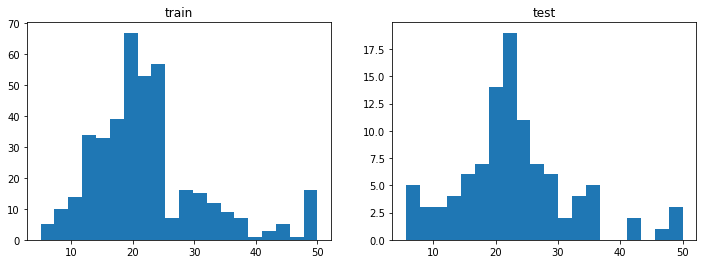

In [3]:
# 예측값(targets)의 분포 확인
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.hist(train_targets, bins=20)
plt.title('train')
plt.subplot(122)
plt.hist(test_targets, bins=20)
plt.title('test')

### 3.6.2 데이터 준비
정규화  
테스트셋도 훈련셋의 평균과 분산으로 정규화를 시켜줌, 테스트셋으로 계산한 어떠한 값도 사용해서는 안됨(Data Leakage)

In [6]:
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

### 3.6.3 모델 구성
64개의 유닛을 가진 2개의 은닉층으로 구성  
훈련 데이터의 수가 작을수록 과대적합이 잘 일어나므로 작은 모델을 사용하는 것이 적합

In [12]:
from keras import models, layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1)) # activation = 'None' 연속적인 값
  model.compile(optimizer='rmsprop',
                loss='mse',
                metrics=['mae']) # MAE = 0.5면 평균적으로 0.5*1천달러 = 500달러 정도 차이난다는 뜻
  return model

### 3.6.4 K-겹 검증을 이용한 훈련 검증
데이터셋의 크기가 작을 때 K-겹 검증을 사용하여 모델 평가

In [59]:
# 코드 3-27 K-겹 검증하기
import numpy as np
k = 4
all_scores = []
num_epochs=10
num_samples = train_data.shape[0]//k # // : 나누기 연산 후 소수점 이하의 수를 버리고, 정수 부분의 수만 구함
for i in range(k):
  print('처리 중인 폴드 #', i+1)
  val_data = train_data[i*num_samples : (i+1)*num_samples]
  val_targets = train_targets[i*num_samples : (i+1)*num_samples]

  partial_train_data = np.concatenate(
      (train_data[:i*num_samples],
       train_data[(i+1)*num_samples:]), axis=0
  )
  partial_train_targets = np.concatenate(
      (train_targets[:i*num_samples],
       train_targets[(i+1)*num_samples:]), axis=0
  )

  model = build_model()
  model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs,
            batch_size=1, verbose=0,
            validation_data=(val_data, val_targets)) # verbose : 훈련 과정을 출력(1)/미출력(0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
  all_scores.append(val_mae)

처리 중인 폴드 # 1
처리 중인 폴드 # 2
처리 중인 폴드 # 3
처리 중인 폴드 # 4


In [60]:
print(all_scores)
np.mean(all_scores)

[2.1295907497406006, 2.83856201171875, 2.6996450424194336, 2.7178332805633545]


2.5964077711105347

In [62]:
# 코드 3-28 각 폴드에서 검증 점수 로그에 저장하기
import numpy as np
k = 4

all_mae_history = []
num_epochs=500
num_samples = train_data.shape[0]//k # // : 나누기 연산 후 소수점 이하의 수를 버리고, 정수 부분의 수만 구함
for i in range(k):
  print('처리 중인 폴드 #', i+1)
  val_data = train_data[i*num_samples : (i+1)*num_samples]
  val_targets = train_targets[i*num_samples : (i+1)*num_samples]

  partial_train_data = np.concatenate(
      (train_data[:i*num_samples],
       train_data[(i+1)*num_samples:]), axis=0
  )
  partial_train_targets = np.concatenate(
      (train_targets[:i*num_samples],
       train_targets[(i+1)*num_samples:]), axis=0
  )

  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets,
            epochs=num_epochs,
            batch_size=1, verbose=0,
            validation_data=(val_data, val_targets)) # verbose : 훈련 과정을 출력(1)/미출력(0)
  mae_history = history.history['mae']
  all_mae_history.append(mae_history)

처리 중인 폴드 # 1
처리 중인 폴드 # 2
처리 중인 폴드 # 3
처리 중인 폴드 # 4


In [63]:
print(all_scores)
print(np.mean(all_scores))

print(len(all_mae_history))
print(all_mae_history)

[2.1295907497406006, 2.83856201171875, 2.6996450424194336, 2.7178332805633545]
2.5964077711105347
4
[[10.942683219909668, 3.828794479370117, 3.2073049545288086, 2.8068182468414307, 2.673877000808716, 2.6891751289367676, 2.451871871948242, 2.4829328060150146, 2.3620898723602295, 2.3736448287963867, 2.3484950065612793, 2.2800800800323486, 2.216888427734375, 2.169375419616699, 2.1570262908935547, 2.0974650382995605, 2.133007526397705, 2.1686978340148926, 2.0867931842803955, 2.0877630710601807, 2.04841685295105, 2.055560827255249, 2.0307416915893555, 1.956007957458496, 1.9497339725494385, 2.052203416824341, 1.9681601524353027, 1.9517799615859985, 1.9236137866973877, 1.8638420104980469, 1.9302871227264404, 1.8649846315383911, 1.8666025400161743, 1.8919919729232788, 1.9033308029174805, 1.876278281211853, 1.7976253032684326, 1.8523194789886475, 1.8437268733978271, 1.8269463777542114, 1.8167253732681274, 1.7718993425369263, 1.8536041975021362, 1.7725995779037476, 1.7928327322006226, 1.72526705

In [64]:
# 코드 3-29 K-겹 검증 평균을 기록하기, 각 epoch당 mae의 평균
average_mae_history = [
  np.mean([x[i] for x in all_mae_history]) for i in range(num_epochs)
]
print(len(average_mae_history))
print(average_mae_history)

500
[10.328929662704468, 3.717398166656494, 3.0535032153129578, 2.746542453765869, 2.54811030626297, 2.5002156496047974, 2.3932318687438965, 2.3589910864830017, 2.2471386194229126, 2.236473798751831, 2.204219400882721, 2.172067642211914, 2.10682213306427, 2.0897399187088013, 2.0822627246379852, 2.054732322692871, 2.0075255036354065, 2.02238792181015, 1.9964343011379242, 1.9592222571372986, 1.9654939770698547, 1.9502674341201782, 1.9174750447273254, 1.9095393121242523, 1.8941159844398499, 1.900941550731659, 1.84177565574646, 1.85666161775589, 1.8485578894615173, 1.8123445212841034, 1.7964441180229187, 1.819632649421692, 1.787027359008789, 1.7725538313388824, 1.7744964361190796, 1.739271879196167, 1.7251884639263153, 1.7425737380981445, 1.7223889231681824, 1.726671576499939, 1.692421317100525, 1.683603674173355, 1.7071571052074432, 1.6834184527397156, 1.6964390277862549, 1.6724503934383392, 1.6373590230941772, 1.6255388855934143, 1.60830557346344, 1.619893103837967, 1.6207249760627747, 1

Text(0, 0.5, 'Average MAE')

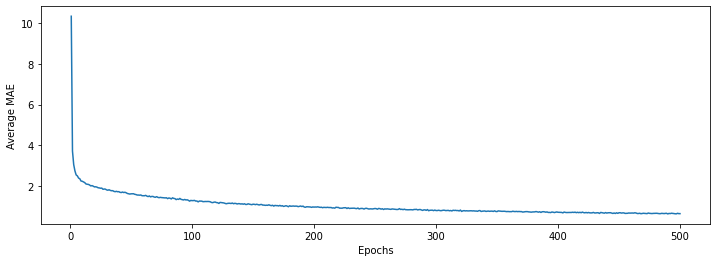

In [65]:
# 코드 3-30 검증 점수 그래프
plt.figure(figsize=(12,4))
plt.plot(range(1, len(average_mae_history)+1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Average MAE')

범위가 크고 변동이 심하기 때문에 시각적X
- 곡선의 다른 부분과 스케일이 많이 다른 첫 10개의 데이터 포인트를 제외
- 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균(exponential moving average)로 대체

In [68]:
# 코드 3-31 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points :
    if smoothed_points :
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
      print(smoothed_points)
    else :
      smoothed_points.append(point)
      print(smoothed_points)

    return smoothed_points

[2.204219400882721]


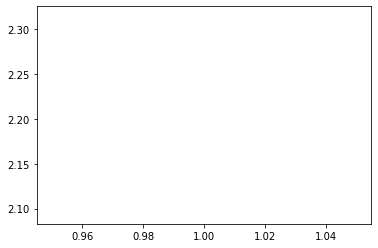

In [69]:
y = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(y)+1), y)

In [70]:
len(average_mae_history[10:])
smooth_curve(average_mae_history[10:])

[2.204219400882721]


[2.204219400882721]

In [72]:
# 코드 3-32 최종 모델 훈련시키기
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(test_mae_score)

4/4 [==============================] - 0s 3ms/step - loss: 17.8816 - mae: 2.6436
2.6435887813568115


### 3.6.5 정리
- 회귀에서의 손실함수 : 평균 제곱 오차(MSE), 평가 지표 : 평균 절대 오차(MAE)
- 입력 데이터의 피처가 서로 다른 범위를 가지면 전처리 단계에서 스케일링
- 사용 가능한 데이터 수가 적다면 K-겹 검증을 사용하여 모델 평가
- 사용 가능한 데이터 수가 적다면 과대적합을 피하기 위해 은닉 층의 수를 줄인 모델이 좋음 (일반적으로 1개 또는 2개)